<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive


WEIGHTSANDBIASES = True
DOWNLOAD = False
CROPPING = True
SEGMENTATION = True
CLAHE = False

# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'



drive.mount('/content/drive')


if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

  !kaggle datasets download -d "tschandl/ham10000-lesion-segmentations"

  !unzip -o ham10000-lesion-segmentations.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# !mkdir -p ~/.kaggle
# !mv /content/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [5]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [6]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __setmasks__(self,masks):
      self.masks = masks

  def __getmask__(self,i):
      return self.masks[i]

  def __lenmasks__(self):
    return len(self.masks)

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getpath__(self,index):
    return self.paths[index]

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if SEGMENTATION:
        mask = cv2.imread(self.masks[index], cv2.IMREAD_GRAYSCALE)
        _, mask_binaria = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        image = cv2.bitwise_and(image, image, mask=mask_binaria)

        non_black_pixels = np.where(image > 0)

        x_min, x_max = np.min(non_black_pixels[1]), np.max(non_black_pixels[1])
        y_min, y_max = np.min(non_black_pixels[0]), np.max(non_black_pixels[0])

        marge = 10
        if ((x_min - marge) >= 0):
            x_min = x_min - marge
        if ((x_max + marge) <= 224):
            x_max = x_max + marge

        if CROPPING:
          image = image[y_min:y_max, x_min:x_max]

        # print(cropped_image.shape)
        image = cv2.resize(image, (299, 299), interpolation=cv2.INTER_CUBIC)

      #preprocessament
      if CLAHE:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge((l_clahe, a, b))
        image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)




      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [7]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [8]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)

  mask_files = sorted(glob('/content/sample_data/HAM10000_segmentations_lesion_tschandl/*'))

  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  mask_path_dict = {os.path.splitext(os.path.basename(x))[0].replace('_segmentation', ''): x for x in mask_files}

  #print(mask_path_dict)

  #{'ISIC_0024306_segmentation': '/content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0024306_segmentation.png'

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['mask_path'] = metadates['image_id'].map(mask_path_dict.get)

  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)

  if SEGMENTATION:

    train_data.__setmasks__(X_train['mask_path'].to_numpy())
    test_data.__setmasks__(X_test['mask_path'].to_numpy())
    validation_data.__setmasks__(X_val['mask_path'].to_numpy())

  return train_data, validation_data,test_data


In [9]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

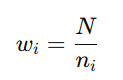

In [10]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [11]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  # elif numero_model == 1:
  #   resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
  #   resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

  #   pos_weight = torch.tensor(weights,device = device)
  #   loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  #   return resnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    googlenet = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    googlenet.aux_logits = False

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 3:
    efficientnet = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.classifier[1].in_features
    efficientnet.classifier[1] = nn.Linear(in_features=num_features, out_features=1)

    return efficientnet,loss_fn

  elif numero_model == 4:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  # elif numero_model == 6:

  #   resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
  #   num_features = resnetmulticlass.fc.in_features
  #   resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

  #   weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
  #   loss_fn = nn.CrossEntropyLoss(weight=weights)

  #   return resnetmulticlass,loss_fn

  elif numero_model == 5:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 6:

    googlenetmulticlass = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

    return googlenetmulticlass,loss_fn

  elif numero_model == 7:

    efficientnetmulticlass = models.efficientnet_b1(weights='IMAGENET1K_V1')

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = efficientnetmulticlass.classifier[1].in_features
    efficientnetmulticlass.classifier[1] = nn.Linear(in_features=num_features, out_features=7)

    return efficientnetmulticlass,loss_fn



In [12]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [13]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        if isinstance(output, tuple) or hasattr(output, 'logits'):
                output = output.logits

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [14]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)

            if isinstance(output, tuple) or hasattr(output, 'logits'):
                output = output.logits


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [15]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 5
  requerit = 0.010
  last_loss = float('inf')

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_loss - requerit < train_loss:
            print("Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!")
            break
        else:
          interval = 5
          last_loss = train_loss

  return model

In [16]:
def test(model,dataloader,weights_dir,loss_fn,device):

  model.load_state_dict(torch.load(weights_dir))

  test_acc = 0
  test_f1 = 0
  test_recall = 0
  test_precision = 0
  test_loss = 0

  json_obj = []

  model.eval()

  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(dataloader):

            input_img = input_img.to(device)
            output = model(input_img)

            if isinstance(output, tuple) or hasattr(output, 'logits'):
                output = output.logits

            dades = {}

            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = (output.cpu().detach().numpy() > 0.5).astype(int)

            dades["target"] = target.cpu().detach().tolist()

            target = target.cpu().detach().numpy()

            dades["top1-accuracy"] = accuracy_score(target,output)
            test_acc  += dades["top1-accuracy"]
            dades["f1-score"] = f1_score(target,output,average='weighted',zero_division=1)
            test_f1 += dades["f1-score"]
            dades["recall"] = recall_score(target,output,average='weighted',zero_division=1)
            test_recall += dades["recall"]
            dades["precision"] = precision_score(target,output,average='weighted',zero_division=1)
            test_precision += dades["precision"]

            dades["loss"] = loss.item()
            test_loss += dades["loss"]

            json_obj.append(dades)


  return json_obj

In [17]:
def veure_imatges(train_data):
  for i in range(len(train_data)):
    path = train_data.__getpath__(i)
    clean_img = cv2.imread(path)
    mean, std = cv2.meanStdDev(clean_img)

    clean_img = cv2.resize(clean_img, (224, 224))
    clean_img = torch.tensor(clean_img).permute(2, 0, 1)  # Convert to (C, H, W)

    print(clean_img.shape)

    imatge,label = train_data.__getitem__(i)
    print(imatge.shape)
    std = std.flatten()
    mean = mean.flatten()
    imatge = imatge * (std[:, None, None]) + (mean[:, None, None])

    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    clean_img = clean_img.permute(1, 2, 0).numpy() #clean_img no es un torch

    combined_image = np.concatenate((img_numpy, clean_img), axis=1)
    cv2_imshow(combined_image)

    time.sleep(5)
    clear_output(wait=True)

In [18]:
from itertools import product
BINARY = False #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet152':1,'inceptionv3':2,'efficientnetb1':3,'alexnetmulticlass':4,'resnet152multiclass':5,'inceptionv3multiclass':6,'efficientnetb1multiclass':7}
img_sizes = {'alexnet': 224,'resnet152':224,'inceptionv3':299,'efficientnetb1':224,'alexnetmulticlass':224,'resnet152multiclass':224,'inceptionv3multiclass':299,'efficientnetb1multiclass':224}

nom_model = 'inceptionv3multiclass'
MODEL = architectures[nom_model]

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = img_sizes[nom_model]


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None

if SEGMENTATION == False:
  transform = transforms.Compose([
      transforms.Resize((SIZE,SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std)
  ])

  transform_training = transforms.Compose([
      transforms.Resize((SIZE,SIZE)),
      transforms.RandomHorizontalFlip(p=0.3),
      transforms.RandomVerticalFlip(p=0.3),
      transforms.RandomRotation(degrees=20),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std),
  ])
else:
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std)
  ])

  transform_training = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.3),
      transforms.RandomVerticalFlip(p=0.3),
      transforms.RandomRotation(degrees=20),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std),
  ])

CLAHE = False
train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)


EPOCHS = 60
batch_size = 32

binary_weights, multiple_weights = get_weights()

if MODEL < 4:
  weights = binary_weights
else:
  weights = multiple_weights

print(weights)
learning_rate  = 1e-5


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

model,loss_fn = tria_model(MODEL,weights)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)

projectes = ['Ham10000-AlexnetBinary','Ham1000-Resnet152Binary','Ham10000-Inceptionv3Binary','Ham10000-EfficientNetB1Binary',
              'Ham10000-AlexnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-Inceptionv3Multiclass','Ham10000-EfficientNetB1Multiclass']

if WEIGHTSANDBIASES:
    wandb.init(
            project=projectes[MODEL],
            config={
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "weights":weights,
                "CLAHE": CLAHE,
                })
    config = wandb.config
    print(config)


parametres_training = {
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "testsize":len(test_loader),
                "testdist": TESTING,
                "loss_weights":str(weights),
                "SEGMENTATION": SEGMENTATION,
                "CROPPING": CROPPING,
                "img_size": SIZE,
                "random_state": 42,
                "WeightsAndBiases": wandb.run.get_url(),
                "data_augmentation": str(transform_training)
}

carpeta_drive = '/content/drive/MyDrive/Runs/' + projectes[MODEL]
os.makedirs(carpeta_drive, exist_ok=True) #cream la carpeta si no existeix

current_runs = len([d for d in os.listdir(carpeta_drive) if os.path.isdir(os.path.join(carpeta_drive, d))]) #número d'execucions fetes de cada model

#cada execució tindrà la seva carpeta numerada

json_object = json.dumps(parametres_training,indent = 2)

#cream la carpeta de l'execució

num_execucio = str(current_runs)
carpeta_execucio = carpeta_drive+"/"+ num_execucio
os.makedirs(carpeta_execucio,exist_ok=True)

#afegim la informació d'entrenament a la carpeta
with open(carpeta_execucio+"/training_info.json", "w") as outfile:
  outfile.write(json_object)

#guardam els pesos a la carpeta de drive
best_model = execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+num_execucio+'.pt'
torch.save(model.state_dict(), carpeta_pesos )

#també guardam els resultats del test a la carpeta de drive
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+str(current_runs)+'.pt'

resultats = test(model,test_loader,carpeta_pesos,loss_fn,device)

with open(carpeta_execucio+"/testing_info.json", "w") as outfile:
    json.dump(resultats, outfile, indent=3)


wandb.finish()

[0.00657042 0.03958192 0.04008614 0.08570948 0.13472377 0.31024417
 0.3830841 ]


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 183MB/s] 


wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


{'epochs': 60, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': [0.0065704208816761995, 0.03958191555403316, 0.04008614377765142, 0.08570947862186559, 0.13472376761969088, 0.31024416909604874, 0.383084104449034], 'CLAHE': False}


  0%|          | 0/60 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 1.727639246271901
Accuracy train epoch: 1  train_acc: 0.37504527345164795
F1 train epoch: 1  train_f1: 0.43240487359196045
Recall train epoch: 1  train_recall: 0.37504527345164795


Pèrdua validació epoch: 1  val_loss: 1.4474037699401379
Accuracy val epoch: 1  val_acc: 0.5763671875
F1 val epoch: 1  val_f1: 0.6273024907469713
Recall val epoch: 1  val_recall: 0.5763671875
Recall val epoch: 1  val_precision: 0.7777648078917611


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 1.229219714483892
Accuracy train epoch: 2  train_acc: 0.5671631655197392
F1 train epoch: 2  train_f1: 0.6261911190454438
Recall train epoch: 2  train_recall: 0.5671631655197392


Pèrdua validació epoch: 2  val_loss: 1.0423680320382118
Accuracy val epoch: 2  val_acc: 0.6376953125
F1 val epoch: 2  val_f1: 0.687530227131532
Recall val epoch: 2  val_recall: 0.6376953125
Recall val epoch: 2  val_precision: 0.8141839674554973


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.9275689385089266
Accuracy train epoch: 3  train_acc: 0.6442185802245562
F1 train epoch: 3  train_f1: 0.6977196071539203
Recall train epoch: 3  train_recall: 0.6442185802245562


Pèrdua validació epoch: 3  val_loss: 0.8626186577603221
Accuracy val epoch: 3  val_acc: 0.6955078125
F1 val epoch: 3  val_f1: 0.7303725453810155
Recall val epoch: 3  val_recall: 0.6955078125
Recall val epoch: 3  val_precision: 0.831382041577596


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.7608403767722537
Accuracy train epoch: 4  train_acc: 0.6882809670409271
F1 train epoch: 4  train_f1: 0.7354965125594998
Recall train epoch: 4  train_recall: 0.6882809670409271


Pèrdua validació epoch: 4  val_loss: 0.7438500626012683
Accuracy val epoch: 4  val_acc: 0.7349609375
F1 val epoch: 4  val_f1: 0.7662586783055588
Recall val epoch: 4  val_recall: 0.7349609375
Recall val epoch: 4  val_precision: 0.8394281667046457


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.6871710239178631
Accuracy train epoch: 5  train_acc: 0.7194064650488953
F1 train epoch: 5  train_f1: 0.7590867696936737
Recall train epoch: 5  train_recall: 0.7194064650488953


Pèrdua validació epoch: 5  val_loss: 0.6475289948284626
Accuracy val epoch: 5  val_acc: 0.762890625
F1 val epoch: 5  val_f1: 0.7855868779669164
Recall val epoch: 5  val_recall: 0.762890625
Recall val epoch: 5  val_precision: 0.8492718281366572


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.5953836811491218
Accuracy train epoch: 6  train_acc: 0.7455292466497646
F1 train epoch: 6  train_f1: 0.7821431072790124
Recall train epoch: 6  train_recall: 0.7455292466497646


Pèrdua validació epoch: 6  val_loss: 0.5826266775839031
Accuracy val epoch: 6  val_acc: 0.7720703125
F1 val epoch: 6  val_f1: 0.7996483279005638
Recall val epoch: 6  val_recall: 0.7720703125
Recall val epoch: 6  val_precision: 0.8681616077763341


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.5546205011140778
Accuracy train epoch: 7  train_acc: 0.7584887721839912
F1 train epoch: 7  train_f1: 0.7928397379203799
Recall train epoch: 7  train_recall: 0.7584887721839912


Pèrdua validació epoch: 7  val_loss: 0.5674920710735023
Accuracy val epoch: 7  val_acc: 0.784375
F1 val epoch: 7  val_f1: 0.8053674844170676
Recall val epoch: 7  val_recall: 0.784375
Recall val epoch: 7  val_precision: 0.8666540164850455


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.482778321283747
Accuracy train epoch: 8  train_acc: 0.7759190510684535
F1 train epoch: 8  train_f1: 0.8081527500546102
Recall train epoch: 8  train_recall: 0.7759190510684535


Pèrdua validació epoch: 8  val_loss: 0.5128304329700768
Accuracy val epoch: 8  val_acc: 0.7974609375
F1 val epoch: 8  val_f1: 0.8174257835504508
Recall val epoch: 8  val_recall: 0.7974609375
Recall val epoch: 8  val_precision: 0.8718998015873015


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.43889069144588067
Accuracy train epoch: 9  train_acc: 0.7964505613908004
F1 train epoch: 9  train_f1: 0.8240549157010209
Recall train epoch: 9  train_recall: 0.7964505613908004


Pèrdua validació epoch: 9  val_loss: 0.48090594075620174
Accuracy val epoch: 9  val_acc: 0.814453125
F1 val epoch: 9  val_f1: 0.833624283968888
Recall val epoch: 9  val_recall: 0.814453125
Recall val epoch: 9  val_precision: 0.8806138678401733


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.3983476665687276
Accuracy train epoch: 10  train_acc: 0.8070332307135096
F1 train epoch: 10  train_f1: 0.8347586972837822
Recall train epoch: 10  train_recall: 0.8070332307135096


Pèrdua validació epoch: 10  val_loss: 0.48282593954354525
Accuracy val epoch: 10  val_acc: 0.8119140625
F1 val epoch: 10  val_f1: 0.828702589222992
Recall val epoch: 10  val_recall: 0.8119140625
Recall val epoch: 10  val_precision: 0.8762623171480639


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.3534536220400457
Accuracy train epoch: 11  train_acc: 0.8135186526620789
F1 train epoch: 11  train_f1: 0.8398425947023149
Recall train epoch: 11  train_recall: 0.8135186526620789


Pèrdua validació epoch: 11  val_loss: 0.4365547376219183
Accuracy val epoch: 11  val_acc: 0.8349609375
F1 val epoch: 11  val_f1: 0.8472020302631664
Recall val epoch: 11  val_recall: 0.8349609375
Recall val epoch: 11  val_precision: 0.8843400408128513


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.31622762038591373
Accuracy train epoch: 12  train_acc: 0.8220979717493662
F1 train epoch: 12  train_f1: 0.8463667242218261
Recall train epoch: 12  train_recall: 0.8220979717493662


Pèrdua validació epoch: 12  val_loss: 0.42759710829705
Accuracy val epoch: 12  val_acc: 0.8333984375
F1 val epoch: 12  val_f1: 0.8439028096495662
Recall val epoch: 12  val_recall: 0.8333984375
Recall val epoch: 12  val_precision: 0.8873805905980331


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.3001701983500762
Accuracy train epoch: 13  train_acc: 0.8391660630206447
F1 train epoch: 13  train_f1: 0.8613451129609189
Recall train epoch: 13  train_recall: 0.8391660630206447


Pèrdua validació epoch: 13  val_loss: 0.4968507627490908
Accuracy val epoch: 13  val_acc: 0.847265625
F1 val epoch: 13  val_f1: 0.8582898157832685
Recall val epoch: 13  val_recall: 0.847265625
Recall val epoch: 13  val_precision: 0.895807039061139


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.28164422681250895
Accuracy train epoch: 14  train_acc: 0.8467720028975009
F1 train epoch: 14  train_f1: 0.8684560767381014
Recall train epoch: 14  train_recall: 0.8467720028975009


Pèrdua validació epoch: 14  val_loss: 0.43336148420348763
Accuracy val epoch: 14  val_acc: 0.8541015625
F1 val epoch: 14  val_f1: 0.865172784976399
Recall val epoch: 14  val_recall: 0.8541015625
Recall val epoch: 14  val_precision: 0.8989097485263353


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.263597839901528
Accuracy train epoch: 15  train_acc: 0.8605690872872148
F1 train epoch: 15  train_f1: 0.8803675972043619
Recall train epoch: 15  train_recall: 0.8605690872872148


Pèrdua validació epoch: 15  val_loss: 0.47175842977594584
Accuracy val epoch: 15  val_acc: 0.8505859375
F1 val epoch: 15  val_f1: 0.8623337098184755
Recall val epoch: 15  val_recall: 0.8505859375
Recall val epoch: 15  val_precision: 0.9042176974385558


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.25129152432202817
Accuracy train epoch: 16  train_acc: 0.8582261861644331
F1 train epoch: 16  train_f1: 0.8776680057173816
Recall train epoch: 16  train_recall: 0.8582261861644331


Pèrdua validació epoch: 16  val_loss: 0.45449616480618715
Accuracy val epoch: 16  val_acc: 0.8619140625
F1 val epoch: 16  val_f1: 0.8704213023503573
Recall val epoch: 16  val_recall: 0.8619140625
Recall val epoch: 16  val_precision: 0.907783022087877


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.22556456024072086
Accuracy train epoch: 17  train_acc: 0.8736531148134734
F1 train epoch: 17  train_f1: 0.8912868190803525
Recall train epoch: 17  train_recall: 0.8736531148134734


Pèrdua validació epoch: 17  val_loss: 0.4477817222941667
Accuracy val epoch: 17  val_acc: 0.86484375
F1 val epoch: 17  val_f1: 0.875346768373348
Recall val epoch: 17  val_recall: 0.86484375
Recall val epoch: 17  val_precision: 0.9101965933894697


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.21749422090699475
Accuracy train epoch: 18  train_acc: 0.8804894060123144
F1 train epoch: 18  train_f1: 0.8970013205020965
Recall train epoch: 18  train_recall: 0.8804894060123144


Pèrdua validació epoch: 18  val_loss: 0.418179068248719
Accuracy val epoch: 18  val_acc: 0.8728515625
F1 val epoch: 18  val_f1: 0.8795205330054026
Recall val epoch: 18  val_recall: 0.8728515625
Recall val epoch: 18  val_precision: 0.9151764239079025


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.19412653869485474
Accuracy train epoch: 19  train_acc: 0.8884801702281782
F1 train epoch: 19  train_f1: 0.9035347307738035
Recall train epoch: 19  train_recall: 0.8884801702281782


Pèrdua validació epoch: 19  val_loss: 0.4321633861400187
Accuracy val epoch: 19  val_acc: 0.8806640625
F1 val epoch: 19  val_f1: 0.8875683949440959
Recall val epoch: 19  val_recall: 0.8806640625
Recall val epoch: 19  val_precision: 0.9218156894218263


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.17866782182122606
Accuracy train epoch: 20  train_acc: 0.8939469395146685
F1 train epoch: 20  train_f1: 0.9085362645933381
Recall train epoch: 20  train_recall: 0.8939469395146685


Pèrdua validació epoch: 20  val_loss: 0.4033853062428534
Accuracy val epoch: 20  val_acc: 0.8916015625
F1 val epoch: 20  val_f1: 0.8981815200049812
Recall val epoch: 20  val_recall: 0.8916015625
Recall val epoch: 20  val_precision: 0.9213919103441627


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.16311965744749482
Accuracy train epoch: 21  train_acc: 0.9047559760956175
F1 train epoch: 21  train_f1: 0.918440255149533
Recall train epoch: 21  train_recall: 0.9047559760956175


Pèrdua validació epoch: 21  val_loss: 0.4036546793067828
Accuracy val epoch: 21  val_acc: 0.8857421875
F1 val epoch: 21  val_f1: 0.8938628939942886
Recall val epoch: 21  val_recall: 0.8857421875
Recall val epoch: 21  val_precision: 0.9230132133397247


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.15473480360857045
Accuracy train epoch: 22  train_acc: 0.9113659000362188
F1 train epoch: 22  train_f1: 0.9229330133673626
Recall train epoch: 22  train_recall: 0.9113659000362188


Pèrdua validació epoch: 22  val_loss: 0.42920305934967473
Accuracy val epoch: 22  val_acc: 0.8779296875
F1 val epoch: 22  val_f1: 0.88565135356469
Recall val epoch: 22  val_recall: 0.8779296875
Recall val epoch: 22  val_precision: 0.915160686282426


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.14908436439426773
Accuracy train epoch: 23  train_acc: 0.9075063382832307
F1 train epoch: 23  train_f1: 0.9202825847128572
Recall train epoch: 23  train_recall: 0.9075063382832307


Pèrdua validació epoch: 23  val_loss: 0.42839068942703307
Accuracy val epoch: 23  val_acc: 0.8783203125
F1 val epoch: 23  val_f1: 0.8874437178931031
Recall val epoch: 23  val_recall: 0.8783203125
Recall val epoch: 23  val_precision: 0.9223731803478414


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.14698190443900477
Accuracy train epoch: 24  train_acc: 0.9103698840999638
F1 train epoch: 24  train_f1: 0.9237067750004031
Recall train epoch: 24  train_recall: 0.9103698840999638


Pèrdua validació epoch: 24  val_loss: 0.4630258653778583
Accuracy val epoch: 24  val_acc: 0.8826171875
F1 val epoch: 24  val_f1: 0.8858946930452757
Recall val epoch: 24  val_recall: 0.8826171875
Recall val epoch: 24  val_precision: 0.9060360434214034


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.13997453225561346
Accuracy train epoch: 25  train_acc: 0.9212241941325606
F1 train epoch: 25  train_f1: 0.9339524356744114
Recall train epoch: 25  train_recall: 0.9212241941325606


Pèrdua validació epoch: 25  val_loss: 0.4140620236285031
Accuracy val epoch: 25  val_acc: 0.889453125
F1 val epoch: 25  val_f1: 0.8973441393808872
Recall val epoch: 25  val_recall: 0.889453125
Recall val epoch: 25  val_precision: 0.9244006648800184


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.12224285039620333
Accuracy train epoch: 26  train_acc: 0.9270531510322347
F1 train epoch: 26  train_f1: 0.9384216456209885
Recall train epoch: 26  train_recall: 0.9270531510322347


Pèrdua validació epoch: 26  val_loss: 0.48328571463935077
Accuracy val epoch: 26  val_acc: 0.8892578125
F1 val epoch: 26  val_f1: 0.8924880386910502
Recall val epoch: 26  val_recall: 0.8892578125
Recall val epoch: 26  val_precision: 0.9194780058827811


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.1122436553343715
Accuracy train epoch: 27  train_acc: 0.9293055052517204
F1 train epoch: 27  train_f1: 0.9389303962996106
Recall train epoch: 27  train_recall: 0.9293055052517204


Pèrdua validació epoch: 27  val_loss: 0.4435558613622561
Accuracy val epoch: 27  val_acc: 0.883203125
F1 val epoch: 27  val_f1: 0.8894830109419478
Recall val epoch: 27  val_recall: 0.883203125
Recall val epoch: 27  val_precision: 0.9244135464183265


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.10660076946524748
Accuracy train epoch: 28  train_acc: 0.9345119521912351
F1 train epoch: 28  train_f1: 0.9437344540288549
Recall train epoch: 28  train_recall: 0.9345119521912351


Pèrdua validació epoch: 28  val_loss: 0.5231909442227334
Accuracy val epoch: 28  val_acc: 0.8974609375
F1 val epoch: 28  val_f1: 0.9022395155946016
Recall val epoch: 28  val_recall: 0.8974609375
Recall val epoch: 28  val_precision: 0.9199269026808311


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.0916365506758253
Accuracy train epoch: 29  train_acc: 0.9406238681637088
F1 train epoch: 29  train_f1: 0.9483063413544188
Recall train epoch: 29  train_recall: 0.9406238681637088


Pèrdua validació epoch: 29  val_loss: 0.44864597474224865
Accuracy val epoch: 29  val_acc: 0.8984375
F1 val epoch: 29  val_f1: 0.9033220548428996
Recall val epoch: 29  val_recall: 0.8984375
Recall val epoch: 29  val_precision: 0.9259752804515459


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.0867978083526352
Accuracy train epoch: 30  train_acc: 0.9485919956537486
F1 train epoch: 30  train_f1: 0.9558627927454733
Recall train epoch: 30  train_recall: 0.9485919956537486


Pèrdua validació epoch: 30  val_loss: 0.47131394245661795
Accuracy val epoch: 30  val_acc: 0.8943359375
F1 val epoch: 30  val_f1: 0.8982966758764608
Recall val epoch: 30  val_recall: 0.8943359375
Recall val epoch: 30  val_precision: 0.9251904658554649


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.08551434797060442
Accuracy train epoch: 31  train_acc: 0.9500860195581311
F1 train epoch: 31  train_f1: 0.957061045788371
Recall train epoch: 31  train_recall: 0.9500860195581311


Pèrdua validació epoch: 31  val_loss: 0.4556885164929554
Accuracy val epoch: 31  val_acc: 0.897265625
F1 val epoch: 31  val_f1: 0.899302178062949
Recall val epoch: 31  val_recall: 0.897265625
Recall val epoch: 31  val_precision: 0.9252280591370065


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.07782172526704126
Accuracy train epoch: 32  train_acc: 0.9520780514306411
F1 train epoch: 32  train_f1: 0.958311568608173
Recall train epoch: 32  train_recall: 0.9520780514306411


Pèrdua validació epoch: 32  val_loss: 0.41168276011012495
Accuracy val epoch: 32  val_acc: 0.9041015625
F1 val epoch: 32  val_f1: 0.9084179766332766
Recall val epoch: 32  val_recall: 0.9041015625
Recall val epoch: 32  val_precision: 0.930859731157243


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.07803661563615519
Accuracy train epoch: 33  train_acc: 0.9534475733429917
F1 train epoch: 33  train_f1: 0.9601437511783324
Recall train epoch: 33  train_recall: 0.9534475733429917


Pèrdua validació epoch: 33  val_loss: 0.46810749382711947
Accuracy val epoch: 33  val_acc: 0.9041015625
F1 val epoch: 33  val_f1: 0.9067659397997294
Recall val epoch: 33  val_recall: 0.9041015625
Recall val epoch: 33  val_precision: 0.9288370353455898


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.06652945162453856
Accuracy train epoch: 34  train_acc: 0.9574316370880116
F1 train epoch: 34  train_f1: 0.9633142706495834
Recall train epoch: 34  train_recall: 0.9574316370880116


Pèrdua validació epoch: 34  val_loss: 0.5078640825813636
Accuracy val epoch: 34  val_acc: 0.8912109375
F1 val epoch: 34  val_f1: 0.8951706830714345
Recall val epoch: 34  val_recall: 0.8912109375
Recall val epoch: 34  val_precision: 0.9222523532711626


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.07072387031275794
Accuracy train epoch: 35  train_acc: 0.9580428286852589
F1 train epoch: 35  train_f1: 0.9638408271091814
Recall train epoch: 35  train_recall: 0.9580428286852589


Pèrdua validació epoch: 35  val_loss: 0.5149077830137685
Accuracy val epoch: 35  val_acc: 0.90078125
F1 val epoch: 35  val_f1: 0.9032237834937848
Recall val epoch: 35  val_recall: 0.90078125
Recall val epoch: 35  val_precision: 0.9334434997739375


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.07217090872980922
Accuracy train epoch: 36  train_acc: 0.9580428286852589
F1 train epoch: 36  train_f1: 0.964650707122894
Recall train epoch: 36  train_recall: 0.9580428286852589


Pèrdua validació epoch: 36  val_loss: 0.564871980343014
Accuracy val epoch: 36  val_acc: 0.8884765625
F1 val epoch: 36  val_f1: 0.8934159169477622
Recall val epoch: 36  val_recall: 0.8884765625
Recall val epoch: 36  val_precision: 0.9200074363083037


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.07315983917133742
Accuracy train epoch: 37  train_acc: 0.9607931908728722
F1 train epoch: 37  train_f1: 0.9663104532968723
Recall train epoch: 37  train_recall: 0.9607931908728722


Pèrdua validació epoch: 37  val_loss: 0.4379528353456408
Accuracy val epoch: 37  val_acc: 0.9041015625
F1 val epoch: 37  val_f1: 0.9048540649584871
Recall val epoch: 37  val_recall: 0.9041015625
Recall val epoch: 37  val_precision: 0.9280757880585698


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.07218309524710256
Accuracy train epoch: 38  train_acc: 0.9588011590003622
F1 train epoch: 38  train_f1: 0.9654803538977718
Recall train epoch: 38  train_recall: 0.9588011590003622


Pèrdua validació epoch: 38  val_loss: 0.4954318650998175
Accuracy val epoch: 38  val_acc: 0.897265625
F1 val epoch: 38  val_f1: 0.8992739820072456
Recall val epoch: 38  val_recall: 0.897265625
Recall val epoch: 38  val_precision: 0.9232695609629378


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.056473881896748485
Accuracy train epoch: 39  train_acc: 0.9691235059760956
F1 train epoch: 39  train_f1: 0.9739470349254189
Recall train epoch: 39  train_recall: 0.9691235059760956


Pèrdua validació epoch: 39  val_loss: 0.5161540764383972
Accuracy val epoch: 39  val_acc: 0.8919921875
F1 val epoch: 39  val_f1: 0.8923764093679342
Recall val epoch: 39  val_recall: 0.8919921875
Recall val epoch: 39  val_precision: 0.9172968042550244


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.05765551114380656
Accuracy train epoch: 40  train_acc: 0.9696554690329591
F1 train epoch: 40  train_f1: 0.9737932662834416
Recall train epoch: 40  train_recall: 0.9696554690329591


Pèrdua validació epoch: 40  val_loss: 0.5176736587309279
Accuracy val epoch: 40  val_acc: 0.9009765625
F1 val epoch: 40  val_f1: 0.9055798388350713
Recall val epoch: 40  val_recall: 0.9009765625
Recall val epoch: 40  val_precision: 0.9327693031933212


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.05509188798890705
Accuracy train epoch: 41  train_acc: 0.9657619521912351
F1 train epoch: 41  train_f1: 0.9705370769049546
Recall train epoch: 41  train_recall: 0.9657619521912351


Pèrdua validació epoch: 41  val_loss: 0.496365929255262
Accuracy val epoch: 41  val_acc: 0.903125
F1 val epoch: 41  val_f1: 0.9056382829808949
Recall val epoch: 41  val_recall: 0.903125
Recall val epoch: 41  val_precision: 0.9307717856479218


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.052127837672814786
Accuracy train epoch: 42  train_acc: 0.9698818362911988
F1 train epoch: 42  train_f1: 0.9743464181797655
Recall train epoch: 42  train_recall: 0.9698818362911988


Pèrdua validació epoch: 42  val_loss: 0.4793152602360351
Accuracy val epoch: 42  val_acc: 0.9052734375
F1 val epoch: 42  val_f1: 0.9071988317481168
Recall val epoch: 42  val_recall: 0.9052734375
Recall val epoch: 42  val_precision: 0.9301456131334697


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.06346452624473974
Accuracy train epoch: 43  train_acc: 0.9651507605939876
F1 train epoch: 43  train_f1: 0.9700102948073479
Recall train epoch: 43  train_recall: 0.9651507605939876


Pèrdua validació epoch: 43  val_loss: 0.45221384859178215
Accuracy val epoch: 43  val_acc: 0.9125
F1 val epoch: 43  val_f1: 0.9151596864788408
Recall val epoch: 43  val_recall: 0.9125
Recall val epoch: 43  val_precision: 0.9400574436496963


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.04785925001499662
Accuracy train epoch: 44  train_acc: 0.9717380478087649
F1 train epoch: 44  train_f1: 0.9754911282204128
Recall train epoch: 44  train_recall: 0.9717380478087649


Pèrdua validació epoch: 44  val_loss: 0.5687657601665705
Accuracy val epoch: 44  val_acc: 0.9072265625
F1 val epoch: 44  val_f1: 0.9116383384181813
Recall val epoch: 44  val_recall: 0.9072265625
Recall val epoch: 44  val_precision: 0.9355947566345387


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.06449266439266652
Accuracy train epoch: 45  train_acc: 0.9692593263310395
F1 train epoch: 45  train_f1: 0.9737935872981246
Recall train epoch: 45  train_recall: 0.9692593263310395


Pèrdua validació epoch: 45  val_loss: 0.5114263811265118
Accuracy val epoch: 45  val_acc: 0.90703125
F1 val epoch: 45  val_f1: 0.9126742164525594
Recall val epoch: 45  val_recall: 0.90703125
Recall val epoch: 45  val_precision: 0.9369220659472268
Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!


train/train_acc,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████
train/train_f1,▁▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train/train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████
train/train_recall,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val/val_acc,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇█▇▇▇▇██████████████████
val/val_f1,▁▂▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇█▇▇▇▇█▇██████████▇█████
val/val_loss,█▅▄▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▂▂▁▂▂▂▂▂▁▂
val/val_precision,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇▇▇█████
val/val_recall,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇█▇▇▇▇██████████████████
train/train_acc,0.96926


In [19]:
# print(validation_data.__getmask__(3))
# print(validation_data.__getpath__(3))
# print(validation_data.__len__())
# print(validation_data.__lenmasks__())